In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import ceil
from datetime import datetime
from tqdm import tqdm
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)


In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.drop(columns='Unnamed: 0', inplace=True, axis=1)
dataset.local_date = pd.to_datetime(dataset.local_date)
dataset.local_date = dataset.local_date.round('H')
dataset['hour'] = dataset.local_date.dt.hour
dataset['day'] = dataset.local_date.dt.day
dataset['revenue'] = dataset.price*dataset.quantity

#удаляем данные не относящиеся к последней неделе
dataset = dataset[dataset.local_date.dt.year >= 2021]
dataset = dataset[dataset.local_date.dt.month >= 2]
dataset = dataset[dataset.local_date.dt.day >= 1]

#удаляем возвраты/отрицательные значения
dataset = dataset[dataset.quantity > 0]
dataset = dataset[dataset.price > 0]

#помечаем колонки как категории
dataset['region'] = dataset['region'].astype('category')
dataset['region_str'] = dataset['region'].astype('category')
dataset['region'] = dataset['region'].cat.codes

#отбрасываем записи без barcode
dataset.dropna(inplace=True)


In [3]:
df = dataset[dataset.barcode.isin(['4600494602269', 
                                   '4600494602481' ,
                                   '5449000000996',
                                   '5449000228970', 
                                   '5449000000286', 
                                   '54491472'
            ])].copy()

# df = dataset[dataset.barcode.isin(['2000000000008', 
                                   
#             ])].copy()
df['local_date'] = pd.to_datetime(df['local_date'])
df.reset_index(drop=True, inplace=True)

In [4]:
mode = 'train'
valid_day = df.local_date.max()-pd.Timedelta(days=1)
regions = dataset.region.unique()

#Разбиваем на обучающую/валидационную выборки
# X_train,Y_train, X_valid, Y_valid, matrix = make_feature(df, regions, valid_day, mode)
# train_df = pd.concat([X_train, Y_train], axis=1)

In [5]:
# load the data 
# df = train_df

# cleanup region name 
df["region_str"] = df["region_str"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
# mapping_dict = {
#     "New South Wales": "NSW",
#     "Northern Territory": "NT",
#     "Queensland": "QLD",
#     "South Australia": "SA",
#     "Victoria": "VIC",
#     "Western Australia": "WA",
#     "ACT": "ACT",
# }

# df["state"] = df["state"].map(mapping_dict)

df = df.groupby(["local_date", "region_str", "barcode"])["quantity"] \
       .sum() \
       .reset_index(drop=False)

# create the bottom level id
df["region_barcode"] = df.apply(lambda x: f"{x['region_str']}_{x['barcode']}", axis=1)

df

local_date           region_str        barcode  quantity                     region_barcode
0     2021-02-01 00:00:00       Алтайский_край  4600494602269       0.0       Алтайский_край_4600494602269
1     2021-02-01 00:00:00       Алтайский_край  4600494602481       0.0       Алтайский_край_4600494602481
2     2021-02-01 00:00:00       Алтайский_край  5449000000286       0.0       Алтайский_край_5449000000286
3     2021-02-01 00:00:00       Алтайский_край  5449000000996       0.0       Алтайский_край_5449000000996
4     2021-02-01 00:00:00       Алтайский_край  5449000228970       0.0       Алтайский_край_5449000228970
...                   ...                  ...            ...       ...                                ...
72925 2021-02-07 01:00:00  Ярославская_область  4600494602481       0.0  Ярославская_область_4600494602481
72926 2021-02-07 01:00:00  Ярославская_область  5449000000286       0.0  Ярославская_область_5449000000286
72927 2021-02-07 01:00:00  Ярославская_область  5449000000996       0.0  Ярославская_область_5449000000996
72928 2021-02-07 01:00:00  Ярославская_область  5449000228970       0.0  Ярославская_область_5449000228970
72929 2021-02-07 01:00:00  Ярославская_область       54491472       0.0       Ярославская_область_54491472

[72930 rows x 5 columns]

In [6]:
# inspect all the regions per state
df.groupby("region_str")["barcode"].apply(set).to_frame()

barcode
region_str                                                                            
Алтайский_край                       {54491472, 5449000228970, 4600494602481, 46004...
Амурская_область                     {54491472, 5449000228970, 4600494602481, 46004...
Архангельская_область                {54491472, 5449000228970, 4600494602481, 46004...
Астраханская_область                 {54491472, 5449000228970, 4600494602481, 46004...
Белгородская_область                 {54491472, 5449000228970, 4600494602481, 46004...
Брянская_область                     {54491472, 5449000228970, 4600494602481, 46004...
Владимирская_область                 {54491472, 5449000228970, 4600494602481, 46004...
Волгоградская_область                {54491472, 5449000228970, 4600494602481, 46004...
Вологодская_область                  {54491472, 5449000228970, 4600494602481, 46004...
Воронежская_область                  {54491472, 5449000228970, 4600494602481, 46004...
Днепропетровская_область             {54491472, 5449000228970, 4600494602481, 46004...
Еврейская_автономная_область         {54491472, 5449000228970, 4600494602481, 46004...
Забайкальский_край                   {54491472, 5449000228970, 4600494602481, 46004...
Ивановская_область                   {54491472, 5449000228970, 4600494602481, 46004...
Иркутская_область                    {54491472, 5449000228970, 4600494602481, 46004...
Кабардино-Балкарская_Республика      {54491472, 5449000228970, 4600494602481, 46004...
Калининградская_область              {54491472, 5449000228970, 4600494602481, 46004...
Калужская_область                    {54491472, 5449000228970, 4600494602481, 46004...
Камчатский_край                      {54491472, 5449000228970, 4600494602481, 46004...
Кемеровская_область                  {54491472, 5449000228970, 4600494602481, 46004...
Кировская_область                    {54491472, 5449000228970, 4600494602481, 46004...
Костромская_область                  {54491472, 5449000228970, 4600494602481, 46004...
Краснодарский_край                   {54491472, 5449000228970, 4600494602481, 46004...
Красноярский_край                    {54491472, 5449000228970, 4600494602481, 46004...
Курганская_область                   {54491472, 5449000228970, 4600494602481, 46004...
Курская_область                      {54491472, 5449000228970, 4600494602481, 46004...
Ленинградская_область                {54491472, 5449000228970, 4600494602481, 46004...
Липецкая_область                     {54491472, 5449000228970, 4600494602481, 46004...
Магаданская_область                  {54491472, 5449000228970, 4600494602481, 46004...
Москва                               {54491472, 5449000228970, 4600494602481, 46004...
Московская_область                   {54491472, 5449000228970, 4600494602481, 46004...
Мурманская_область                   {54491472, 5449000228970, 4600494602481, 46004...
Ненецкий_автономный_округ            {54491472, 5449000228970, 4600494602481, 46004...
Нижегородская_область                {54491472, 5449000228970, 4600494602481, 46004...
Новгородская_область                 {54491472, 5449000228970, 4600494602481, 46004...
Новосибирская_область                {54491472, 5449000228970, 4600494602481, 46004...
Омская_область                       {54491472, 5449000228970, 4600494602481, 46004...
Оренбургская_область                 {54491472, 5449000228970, 4600494602481, 46004...
Орловская_область                    {54491472, 5449000228970, 4600494602481, 46004...
Пензенская_область                   {54491472, 5449000228970, 4600494602481, 46004...
Пермский_край                        {54491472, 5449000228970, 4600494602481, 46004...
Приморский_край                      {54491472, 5449000228970, 4600494602481, 46004...
Псковская_область                    {54491472, 5449000228970, 4600494602481, 46004...
Республика_Адыгея                    {54491472, 5449000228970, 4600494602481, 46004...
Республика_Алтай                     {54491472, 5449000228970, 4600494602481,

In [7]:
# create the bottom level df
df_bottom_level = df.pivot(index="local_date", columns="region_barcode", values="quantity")

# create the middle level df
df_middle_level = df.groupby(["local_date", "region_str"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="local_date", columns="region_str", values="quantity")

# create the total level df
df_total = df.groupby("local_date")["quantity"] \
             .sum() \
             .to_frame() \
             .rename(columns={"quantity": "total"})

# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)
hierarchy_df = hierarchy_df.resample("H") \
                           .sum()

print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")

hierarchy_df

Number of time series at the bottom level: 510
Number of time series at the middle level: 85


Алтайский_край_4600494602269  Алтайский_край_4600494602481  Алтайский_край_5449000000286  Алтайский_край_5449000000996  Алтайский_край_5449000228970  Алтайский_край_54491472  Амурская_область_4600494602269  Амурская_область_4600494602481  Амурская_область_5449000000286  Амурская_область_5449000000996  Амурская_область_5449000228970  Амурская_область_54491472  Архангельская_область_4600494602269  Архангельская_область_4600494602481  Архангельская_область_5449000000286  Архангельская_область_5449000000996  Архангельская_область_5449000228970  Архангельская_область_54491472  Астраханская_область_4600494602269  Астраханская_область_4600494602481  Астраханская_область_5449000000286  Астраханская_область_5449000000996  Астраханская_область_5449000228970  Астраханская_область_54491472  Белгородская_область_4600494602269  Белгородская_область_4600494602481  Белгородская_область_5449000000286  Белгородская_область_5449000000996  Белгородская_область_5449000228970  \
local_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2021-02-01 00:00:00                           0.0                           0.0                           0.0                           0.0                           0.0                      0.0                             0.0                             0.0                             0.0                             0.0                             0.0                        0.0                                  0.0                                  0.0                                  0.0                                  0.0                                  0.0                             0.0                                 0.0                                 0.0                                 0.0                                 0.0                                 0.0                            0.0                                 0.0                                 0.0                                 0.0                                 0.0                                 0.0   
2021-02-01 01:00:00                           0.0                           0.0                           0.0                           0.0                           0.0                      0.0                             0.0                             0.0                             0.0                             0.0                             0.0                        0.0                                  0.0                                  0.0                                  0.0                                  0.0                                  0.0                             0.0                                 0.0                                 0.0                                 0.0                                 0.0                                 0.0                            0.0                                 0.0                                 0.0                                 0.0                                 0.0                                 0.0   
2021-02-01 02:00:00                           0.0

In [8]:
states = df["region_str"].unique()
regions = df["region_barcode"].unique()

total = {'total': list(states)}
state = {k: [v for v in regions if v.startswith(k)] for k in states}
hierarchy = {**total, **state}

# hierarchy

In [9]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_df)
ht

- total
   |- Алтайский_край
   |  |- Алтайский_край_4600494602269
   |  |- Алтайский_край_4600494602481
   |  |- Алтайский_край_5449000000286
   |  |- Алтайский_край_5449000000996
   |  |- Алтайский_край_5449000228970
   |  - Алтайский_край_54491472
   |- Амурская_область
   |  |- Амурская_область_4600494602269
   |  |- Амурская_область_4600494602481
   |  |- Амурская_область_5449000000286
   |  |- Амурская_область_5449000000996
   |  |- Амурская_область_5449000228970
   |  - Амурская_область_54491472
   |- Архангельская_область
   |  |- Архангельская_область_4600494602269
   |  |- Архангельская_область_4600494602481
   |  |- Архангельская_область_5449000000286
   |  |- Архангельская_область_5449000000996
   |  |- Архангельская_область_5449000228970
   |  - Архангельская_область_54491472
   |- Астраханская_область
   |  |- Астраханская_область_4600494602269
   |  |- Астраханская_область_4600494602481
   |  |- Астраханская_область_5449000000286
   |  |- Астраханская_область_54490000009

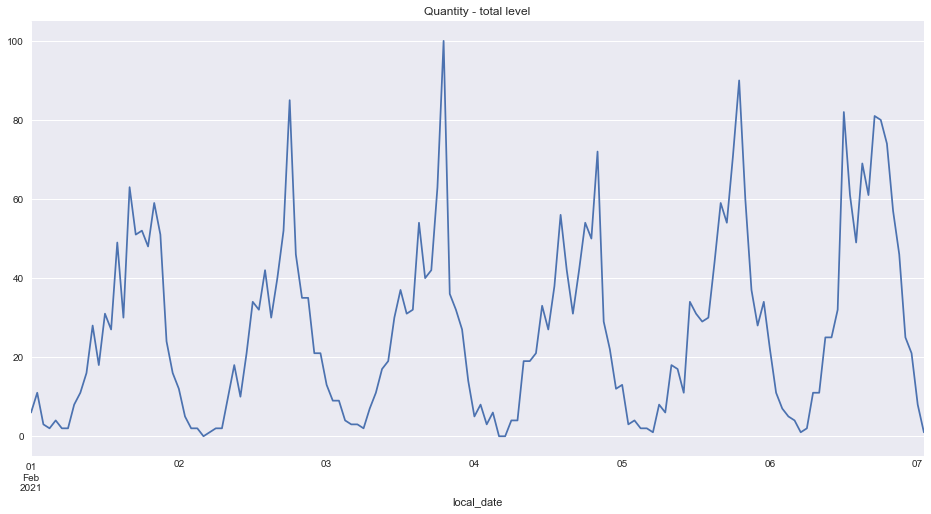

In [10]:
hierarchy_df["total"].plot(title="Quantity - total level");

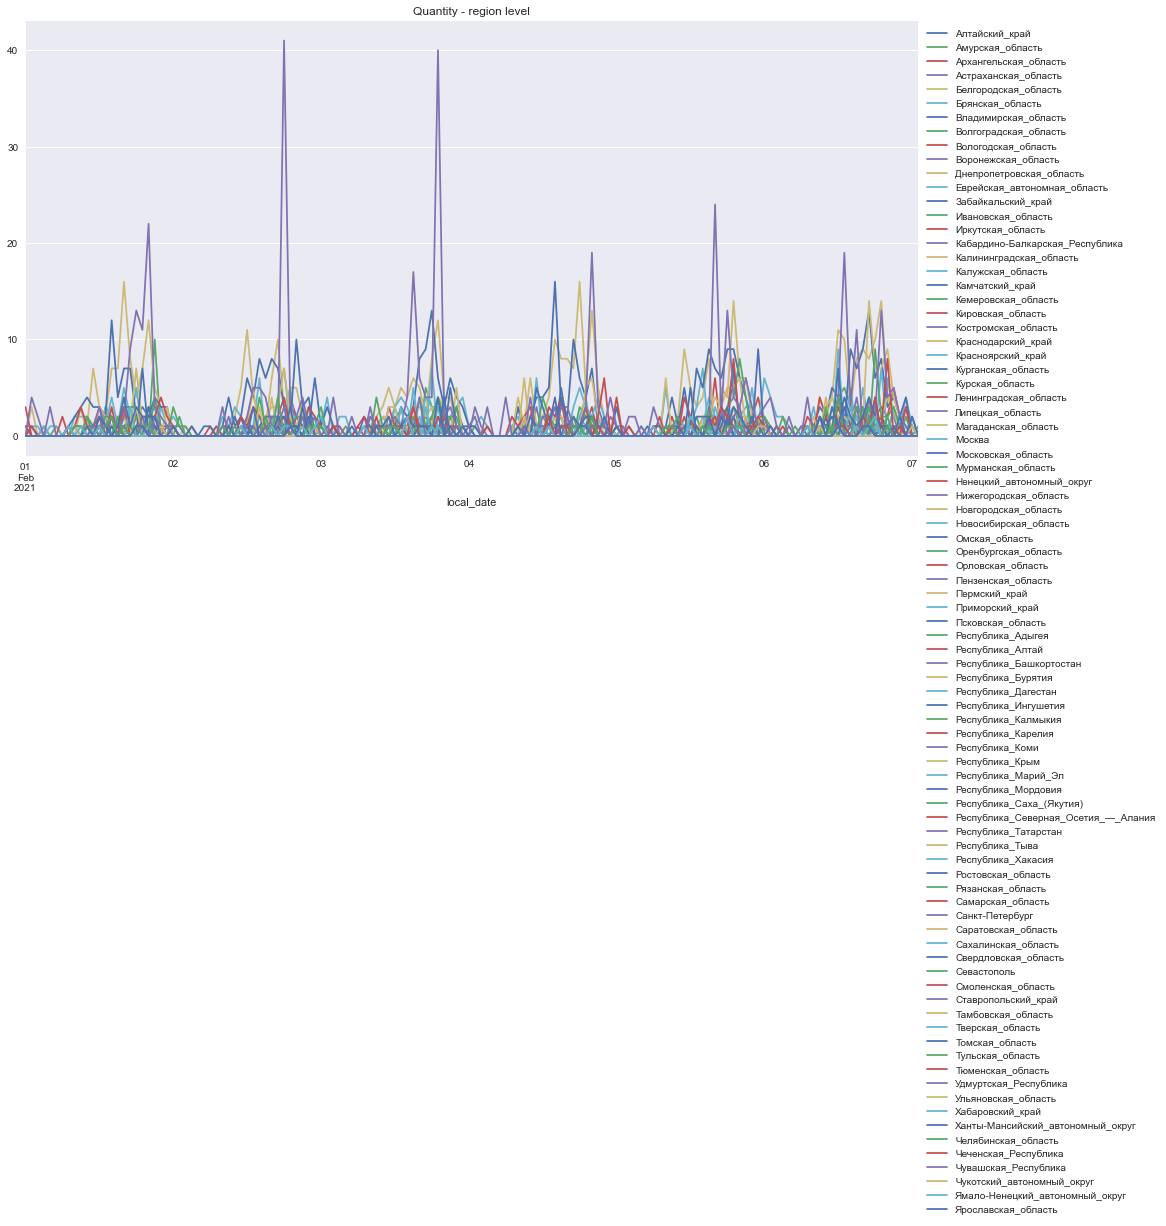

In [11]:
ax = hierarchy_df[hierarchy['total']].plot(title="Quantity - region level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

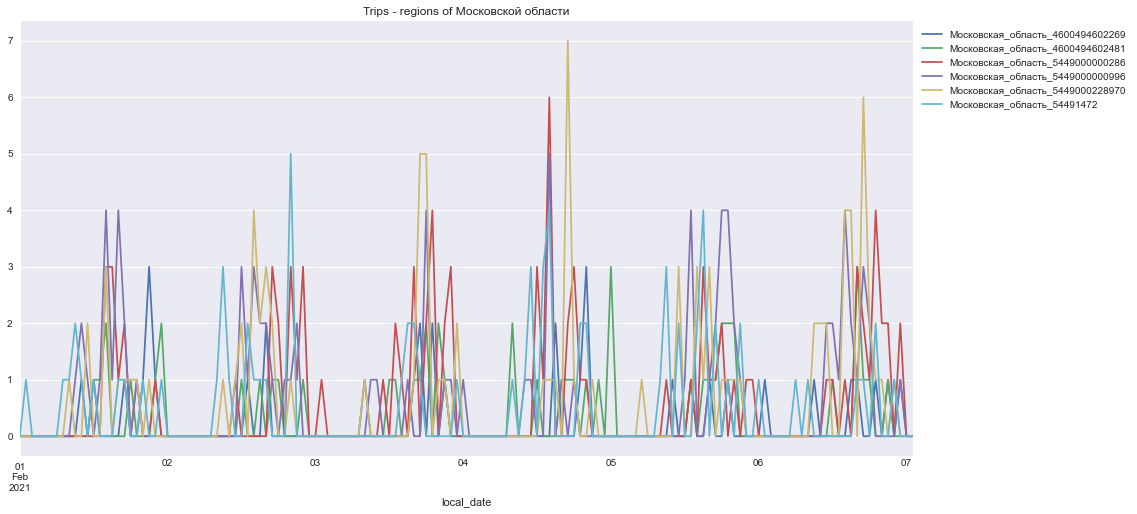

In [12]:
ax = hierarchy_df[hierarchy['Московская_область']].plot(title="Trips - regions of Московской области")
ax.legend(bbox_to_anchor=(1.0, 1.0));

In [13]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Quantity");
    

In [14]:
model_bu_arima = hts.HTSRegressor(model='sarimax', revision_method='WLSS', n_jobs=4)
model_bu_arima = model_bu_arima.fit(hierarchy_df, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=24)

Fitting models: 100%|██████████████████████████| 20/20 [00:04<00:00,  4.45it/s]


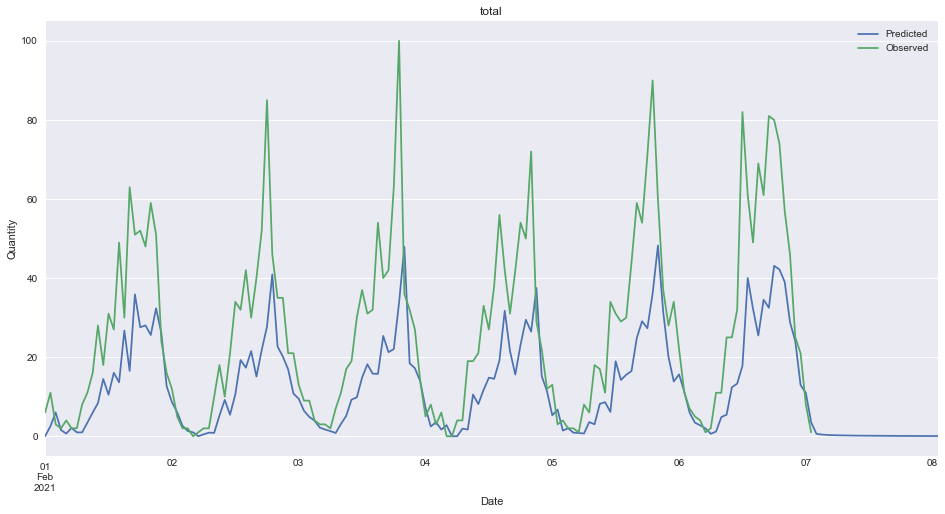

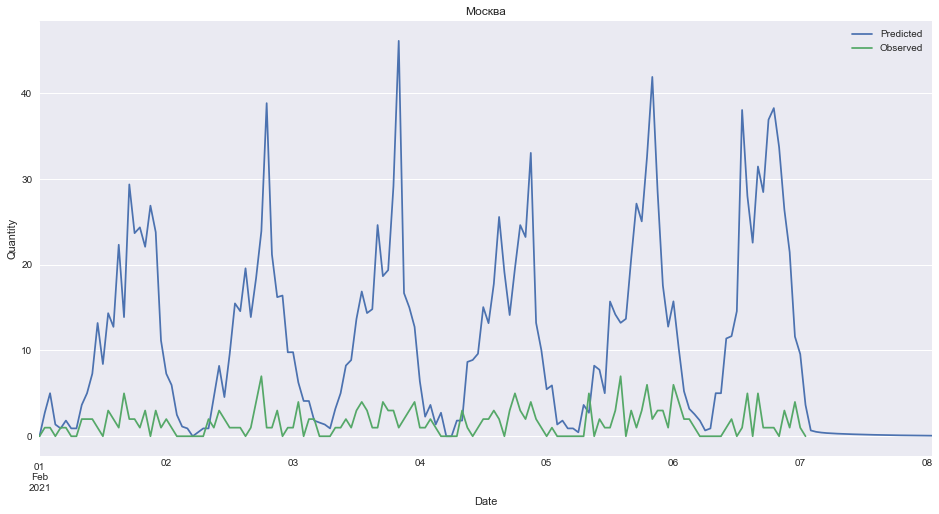

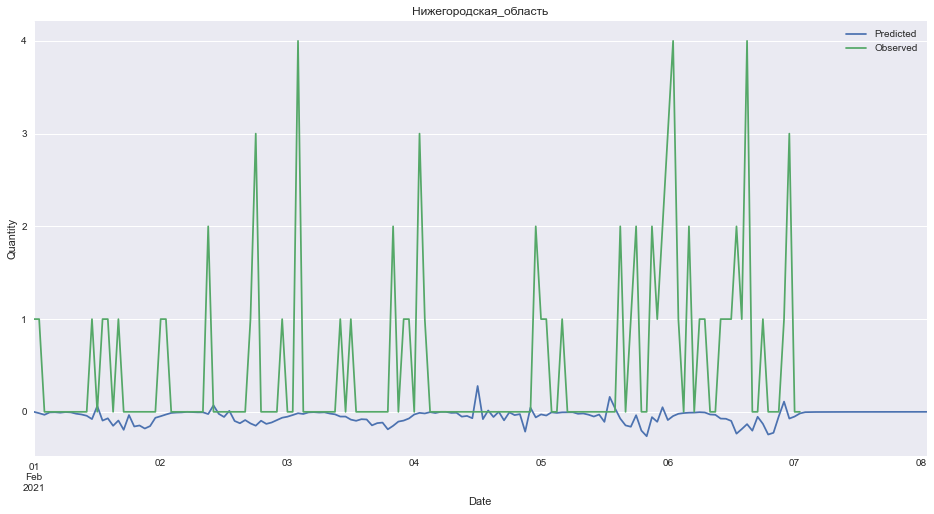

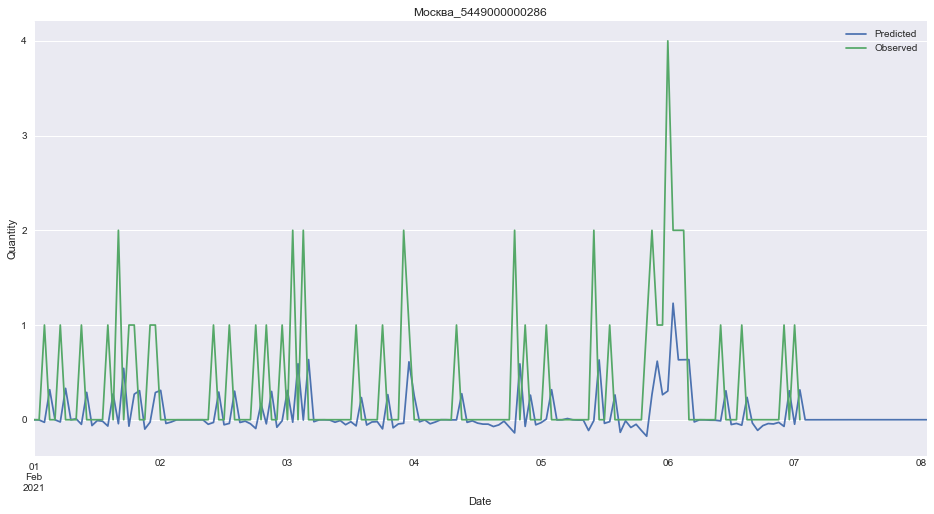

In [15]:
plot_results(pred_bu_arima, hierarchy_df, cols_to_plot=['total'])
plot_results(pred_bu_arima, hierarchy_df, cols_to_plot=['Москва', 'Нижегородская_область'])
plot_results(pred_bu_arima, hierarchy_df, cols_to_plot=['Москва_5449000000286'])

In [16]:
model_td_arima = hts.HTSRegressor(model='holt_winters', revision_method='AHP', n_jobs=4)
model_td_arima = model_td_arima.fit(hierarchy_df, hierarchy)
pred_td_arima = model_td_arima.predict(steps_ahead=24)

Fitting models: 100%|██████████████████████████| 20/20 [00:02<00:00,  7.03it/s]


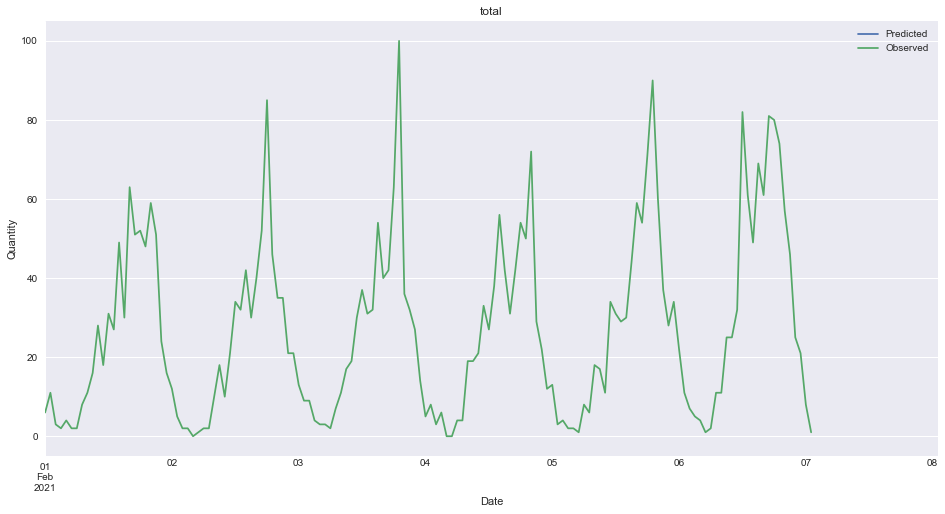

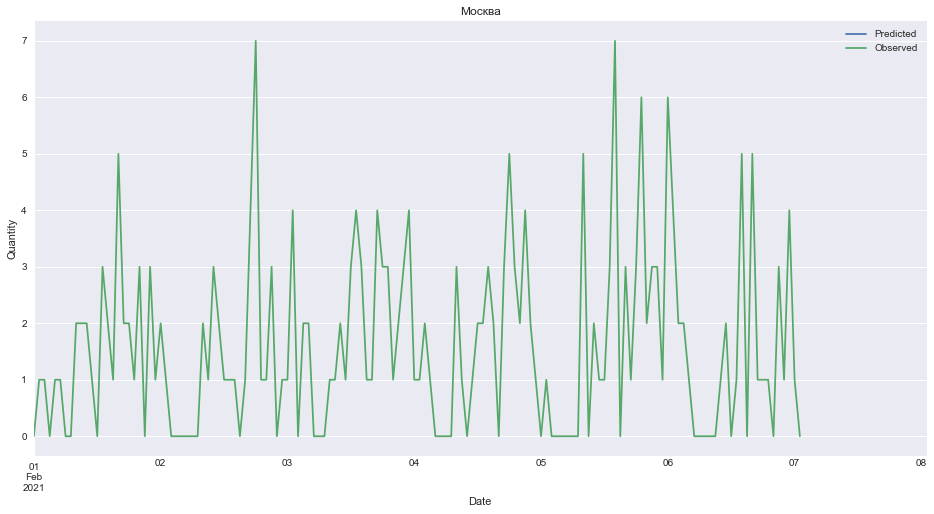

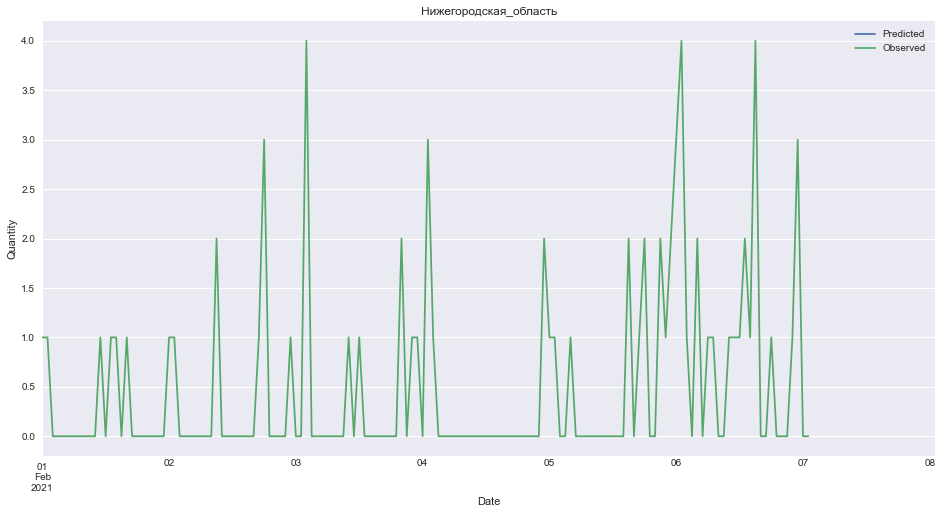

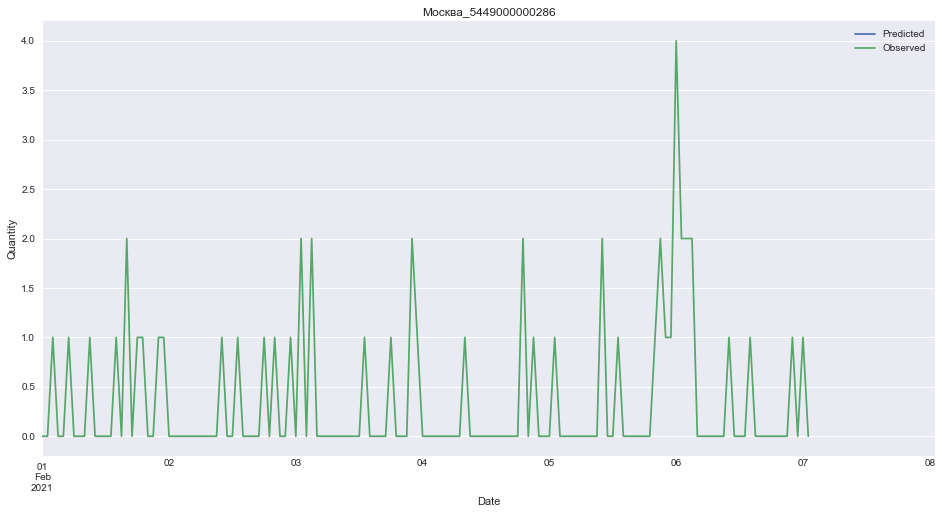

In [20]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['total'])
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['Москва', 'Нижегородская_область'])
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['Москва_5449000000286'])

In [18]:
model_ols_arima = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model_ols_arima = model_ols_arima.fit(hierarchy_df, hierarchy)
pred_ols_arima = model_ols_arima.predict(steps_ahead=24)

Fitting models: 100%|███████████████████████| 596/596 [00:01<00:00, 366.44it/s]


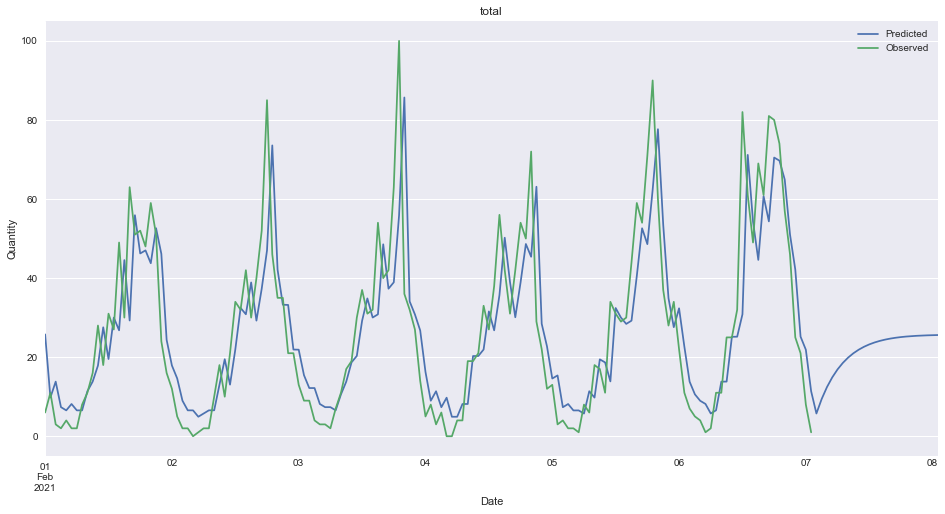

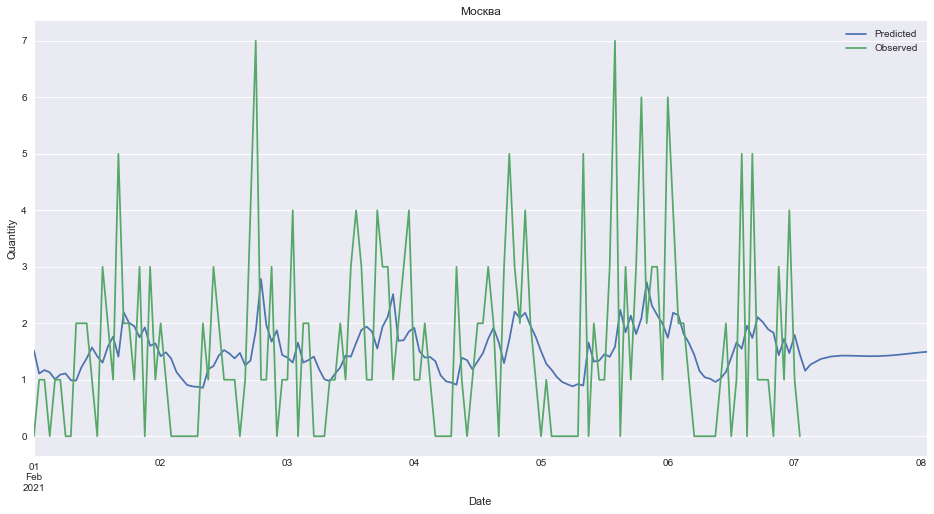

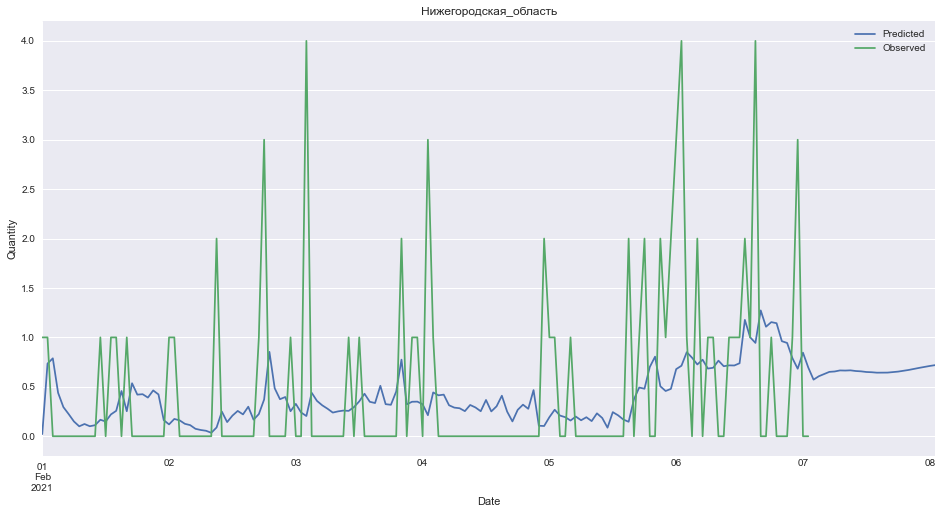

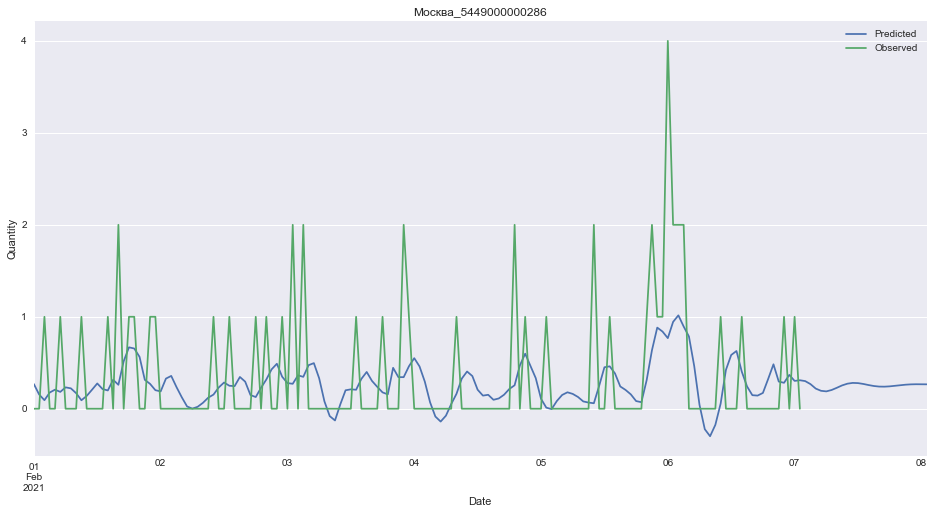

In [19]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['total'])
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['Москва', 'Нижегородская_область'])
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['Москва_5449000000286'])